# Spin Dynamics of an anisotropic XY model on a Cayley Tree

A quick introduction on how to use pyTTN to perform calculations using Tree Tensor Network states.  In this tutorial we demonstrate how to use pyTTN to evaluate the real time spin-dynamics of an anisotropic XY model on a Cayley Tree.  Here we consider a Hamiltonian of the form:

$$ \hat{H} = \sum_{\langle i,j \rangle}\left( (1-\eta)\hat{S}_{xi}\hat{S}_{xj}+(1+\eta)\hat{S}_{yi}\hat{S}_{yj}\right)  +\sum_{i} \hat{S}_{zi} $$

In this example, we consider a depth 6 tree.  Due to the increased complexity of indexing a Cayley tree, this example highlights some more advanced features of the pyTTN library.

### Contents


1. [Importing the Package](#importing-the-package)

2. [Setting up the System and Hamiltonian](#setting-up-the-system-and-hamiltonian)

3. [Preparing the Initial Wavefunction](#preparing-the-initial-wavefunction)

4. [Preparing the `sop_operator` Representation of the Hamiltonian](#preparing-the-sop_operator-hamiltonian)

5. [Setting up Observables](#setting-up-observables)

6. [Setting up and Performing Time Evolution](#setting-up-and-performing-time-evolution)


### Importing the Package

We start by importing the required modules for this example

In [735]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn.utils import visualise_tree

### Setting up the System and Hamiltonian

We start by setting up the `system_modes` object that tells pyTTN the type of operators to expect, and local Hilbert space dimension associated with each mode.  For the case of a depth 6 Cayley tree of degree 3, we have a asystem containing a total of $N=94$ spin-$\frac{1}{2}$.  The system can readily be set up as follows

In [736]:
# Define number of modes
N = 1 + 3 + 3*2 + 3*2*2 + 3*2*2*2 + 3*2*2*2*2

# Initialise system information variable as a set of N modes
sysinf = pyttn.system_modes(N)

# Specify that each mode is a two level system
for i in range(N):
    sysinf[i] = pyttn.spin_mode(2)

We now prepare the system Hamiltonian through the use of the `SOP` class.  This makes use of a string representation of the Hamiltonian, that is later converted into a form necessary for performing calculations.  For more details on the generation of operators see the [tutorial on operator generation](file/../operator_generation.ipynb).  Here we first introduce some a function that constructs an ntree with the connectivity of the Cayley tree and returns a connectivity graph of the network

In [737]:

def get_cayley_connectivity(depth, degree, chi=1):
    def get_nskip(layer):
        ret = 0
        for i in range(layer):
            if i == 0:
                ret += 1
            else: 
                ret += degree*(degree-1)**(i-1)
        return ret

    #unpacks the cayley tree index into a single integer
    def get_index(ind):
        if len(ind) == 0:
            return 0
        else:
            #figure out how many terms are in the Cayley tree of the given size
            c = get_nskip(len(ind))
            ns = [(degree-1)**i for i in reversed(range(len(ind)))]

            for i in range(len(ind)):
                c += ind[i]*ns[i]
            return c

    #insert the root node into the ntree
    topo = pyttn.ntree('(1)')

    inds = []

    #now build each of the Layers around the tree
    if depth-1 > 0:
        #add the first layer
        x = get_index([])
        for i in range(degree):
            y = get_index([i])
            inds.append([x, y])
            topo().insert(chi)

        #now attempt to add all other layers to the tree
        for layer in range(1, depth-1):
            #get all of the leaves of the the tree with the current number of layers
            leaf_indices = topo.leaf_indices()

            #now iterate over each leaf and add its children
            for li in leaf_indices:
                x = get_index(li)
                for i in range(degree-1):
                    topo.at(li).insert(chi)
                    y = get_index(li + [i])
                    inds.append([x, y])
    
    return inds, topo



Now we actually go ahead and set up the Hamiltonian

In [738]:
eta = 0.04

depth=6
degree=3

#get properties of the cayley tree
inds, topo = get_cayley_connectivity(depth, degree)

#set up the system Hamiltonian
H = pyttn.SOP(N)

#add on the onsite fields
for i in range(N):
    H += pyttn.sOP("sz", i)

for ind in inds:
    H += (1-eta)*pyttn.sOP("sx", ind[0])*pyttn.sOP("sx", ind[1])
    H += (1+eta)*pyttn.sOP("sy", ind[0])*pyttn.sOP("sy", ind[1])



### Preparing the Initial Wavefunction

We now prepare the initial wavefunction.  This requires a two-step process, first we define the tree topology to use for this calculation through the use of the `ntree` class (which for this example we choose to be an MPS), following which we construct the `ttn` object that actually represents the wavefunction.  In this example we intend to use a subspace expansion based in order to expand bond dimension throughout the TDVP loop.  In order to do this, we define an additional `ntree` object with the same structure but different values defining the maximum allowed dimension of any bond in the network.  For more details one the construct of tree topologies see the [tutorial on tree topologies](file/../tree_topologies.ipynb). 


In [739]:
# Initial bond dimension
chi = 2

#maximum bond dimension
chi_max = 32

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = sysinf.mode_dimensions()

#now construct an ntree object storing the MPS topology using the ntreeBuilder class
_, topo = get_cayley_connectivity(depth, degree, chi=chi)
_, capacity = get_cayley_connectivity(depth, degree, chi=chi_max)


#now we need to go ahead and add the physical degrees of freedom to each node in the Cayley tree.
#to do this in the correct order we will traverse the ntree depth first search order and append
#the index of each node to the indices array
indices = []
for i in topo.dfs():
    indices.append(i.index())

#here we iterate in the reverse order and add the local physical mode node at the front
#which ensures that we insert the nodes in the correct order.  
for c, ni in enumerate(reversed(indices)):
    topo.at(ni).insert_front(dims[c])
    capacity.at(ni).insert_front(dims[c])

#now allocate the wavefunction object.  And allocate it so that each tensor is filled with random values
A = pyttn.ttn(topo, capacity, dtype=np.complex128)

#and set up the system to be in the state where all spins are down except for the central spin which is up.
state = [0 for i in range(N)]
state[0] = 1
A.set_state(state)

When creating the `ttn` object, tensors will be constructed with the sizes defined in `topo` but with enough space allocated to store the tensors defined in `capacity`.  

### Preparing the `sop_operator` Hamiltonian

Now before we are ready to set up and perform the TDVP loop, we first need to convert the Hamiltonian into a form that can be used to efficiently within the TDVP algorithm.  Here we set the Hamiltonian up as a Hierarchical Sum-of-Product operator by using the default call to sop_operator.  However, we are not yet in a situation where this will give us the expected results.

This is the case as we are currently in a situation where the tree nodes are ordered in a depth first search traversal order but from the definition of the Cayley tree Hamiltonian and the `sysinf` object, the modes are indexed in a breadth first search order.  To remedy this issue, we need to tell the sysinf object how to map modes from its current ordering to the ordering expected for the tree structure.

In [740]:
#traverse the nodes in depth first search order and create a dictionary storing the node and the index the order in which it was reach
dict_dfs = {}
c=0
for  i in topo.dfs():
    if(i.is_leaf()):
        dict_dfs[i] = c
        c=c+1

ordering = []
#now iterate over it in bfs ordering and for the ith leaf in bfs order set it to point to the index in dfs order
for i in topo.bfs():
    if(i.is_leaf()):
        ordering.append(dict_dfs[i])

sysinf.mode_indices = ordering

Now that we have done this mapping we are free to construct the SOP operator.

In [741]:
h = pyttn.sop_operator(H, A, sysinf)

### Setting up Observables

In order to extract the spin-dynamics from this system we need to set up a set of observables to monitor.  Here we will do this by constructing a set of operators defining the average magnetisation associated with each Layer of the Cayley tree.  Additionally, we need to define the `matrix_element` object that will be used for evaluating the actual expectation values.

In [742]:
#set up the observables of interest
ops = []
#add on the central spin magnetisation operator
ops.append(pyttn.site_operator(pyttn.sOP("sz", 0), sysinf))

linds = [ 1,  1 + 3, 1 + 3 + 3*2, 1 + 3 + 3*2 + 3*2*2, 1 + 3 + 3*2 + 3*2*2 + 3*2*2*2, 1 + 3 + 3*2 + 3*2*2 + 3*2*2*2 + 3*2*2*2*2]
#for each other layer
for i in range(depth-1):

    #construct the SOP containing the average magnetisation of the layer
    opS = pyttn.SOP(N)
    for ind in range(linds[i], linds[i+1]):
        opS += (1.0/(linds[i+1]-linds[i]))*pyttn.sOP("sz", ind)

    #and append this to the ops array as a sop_operator.
    ops.append(pyttn.sop_operator(opS, A, sysinf))


#set up the matrix element evaluation code
mel = pyttn.matrix_element(A)

### Setting up and Performing Time Evolution

Now we can have everything we need to set up all of the objects required to perform the TDVP loop.  Here we set up TDVP with the use of subspace expansion to expand bond dimensions throughout the update steps. 

In [743]:
#set up parameters for the time evolution
dt = 0.05
nstep = 100

observables = np.zeros((len(ops), nstep+1))

#set up the TDVP sweeping object.  Here we use subspace expansion evaluating the 6 largest eigenvalues of
#the two site energy variance using a krylov subspace of dimension 12.
sweep = pyttn.tdvp(A, h, krylov_dim=16,  expansion='subspace', subspace_neigs = 6, subspace_krylov_dim=12)

#set up the subspace expansion parameters.  Here we expand bond dimension whenever a term in the 
#two-site energy variance (that is not captured within the single-site spaces) has singular value > 1e-5, 
#and do not use natural populations to determine whether to spawn additional basis functions.
sweep.spawning_threshold = 1e-6
sweep.unoccupied_threshold = 1e-6
sweep.minimum_unoccupied=2

#integration timestep 
sweep.dt = dt
sweep.coefficient = -1.0j

Now we have everything needed to perform the TDVP loop.  Here we perform 10 steps and plot the energy convergence

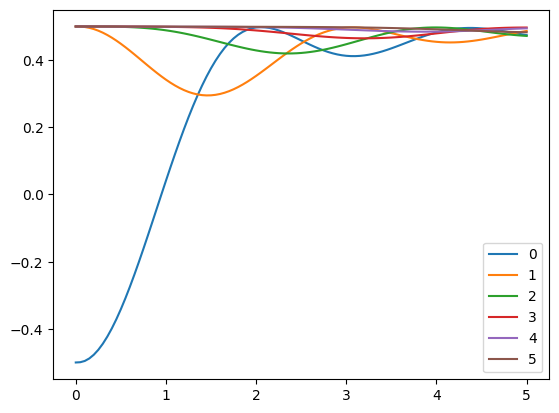

In [744]:
for c in range(len(ops)):
    observables[c, 0] = np.real(mel(ops[c], A))

for i in range(nstep):
    #perform the TDVP step
    sweep(A, h)

    #and print out the energy of the A tensor for the sweep
    print(i+1, end='                                 \r')
    for c in range(len(ops)):
        observables[c, i+1] = np.real(mel(ops[c], A))

t = np.arange(nstep+1)*dt
for c in range(len(ops)):
    plt.plot(t, observables[c, :], label=str(c))
plt.legend()
plt.show()

Now finally, we will visualise what the subspace expansion scheme has done to the bond dimension of the TTN, using the `visualise_tree` function.

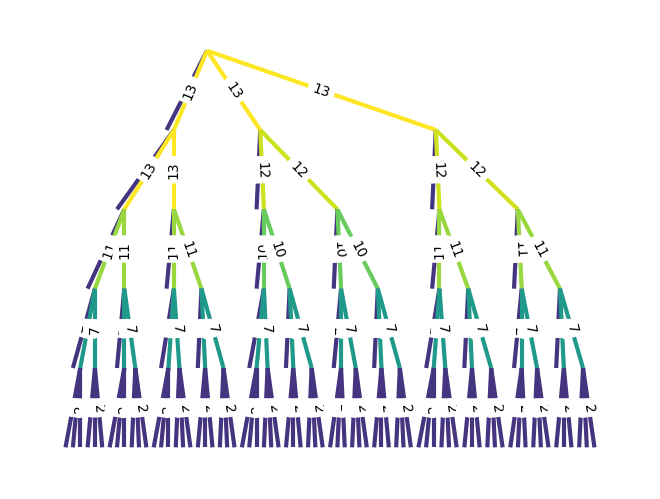

In [746]:
visualise_tree(A, bond_prop="bond dimension", node_size=0, label_all_bonds=True)
plt.show()